# Importing libraries

In [26]:
import pandas as pd
import pyreadr
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from numpy import concatenate
from sklearn.neighbors import LocalOutlierFactor

# Importing and organizing the data

In [2]:
# Load data
robj = pyreadr.read_r('sales.RData')
robj

OrderedDict([('sales',
                         ID   Prod  Quant      Val  Insp
              0          v1     p1    182   1665.0  unkn
              1          v2     p1   3072   8780.0  unkn
              2          v3     p1  20393  76990.0  unkn
              3          v4     p1    112   1100.0  unkn
              4          v3     p1   6164  20260.0  unkn
              ...       ...    ...    ...      ...   ...
              401141  v5918  p4126    113   9330.0  unkn
              401142  v2540  p4126    118   3355.0  unkn
              401143  v5896  p4127    143   1835.0  unkn
              401144  v1796  p4127    102   1445.0  unkn
              401145  v2540  p4127    106   1275.0  unkn
              
              [401146 rows x 5 columns])])

In [3]:
sales = robj['sales']
sales

,ID,Prod,Quant,Val,Insp
0,v1,p1,182,1665.0,unkn
1,v2,p1,3072,8780.0,unkn
2,v3,p1,20393,76990.0,unkn
3,v4,p1,112,1100.0,unkn
4,v3,p1,6164,20260.0,unkn
...,...,...,...,...,...
401141,v5918,p4126,113,9330.0,unkn
401142,v2540,p4126,118,3355.0,unkn
401143,v5896,p4127,143,1835.0,unkn
401144,v1796,p4127,102,1445.0,unkn


In [5]:
# 'Insp' class distribution
print(sales.groupby('Insp').size())

Insp
fraud      1270
ok        14462
unkn     385414
dtype: int64


In [30]:
# checking for transactions that have both the value of Quant and Val missing
(sales['Quant'].isnull() & sales['Val'].isnull()).sum()

888

Removing all 888 cases may be problematic if this leads to removing most transactions of some product or salesperson.

...

In [38]:
# The option of removing all transactions with unknown values on both the quantity and the value is the best option.
for i in range (1, len(sales)):
    if (pd.isna(sales.Quant[i]) & pd.isna(sales.Val[i])):
        sales.drop(labels=i, axis=0, inplace=True)       

# Reseting indexes
sales.reset_index(inplace = True, drop = True)

...

In [39]:
# Deleting the products that have all their transactions with unknown values of the quantity (p2442 and p2443).
for i in range (0, len(sales)-1):
    if (sales.Prod[i] == 'p2442'  or sales.Prod[i] =='p2443'):
        sales.drop(labels=i, axis=0, inplace=True)
    
# Reseting indexes once again
sales.reset_index(inplace = True, drop = True)

In [40]:
# Make a temp copy of the dataframe
temp_df = sales.copy(deep=True)

# We will skip the prices of transactions that were found to be frauds in the calculation of the typical price
for i in range (0, len(temp_df)-1):
    if (temp_df.Insp[i] == 'fraud'):
        temp_df.drop(labels=i, axis=0, inplace=True)
        
#Reset indexes        
temp_df.reset_index(inplace = True, drop = True)

# Obtaining the typical unit price for each product
temp_df["Uprice"] = pd.to_numeric(temp_df["Val"] / temp_df["Quant"])

In [41]:
# Performing groupby on Product and find median of Uprice
df_median = temp_df.groupby(['Prod'])['Uprice'].median().to_frame()
df_median.columns = ['Median']
# Saving index in another column
df_median["Prod"] = df_median.index
# Reseting indexes
df_median.reset_index(inplace = True, drop = True)
# Merging sales and df_median
frame = [sales, df_median]
sales = sales.merge(df_median, on = 'Prod', how = 'inner')

In [42]:
# Having a typical unit price for each product, we can use it to calculate any of the two possibly missing values (Quant and Val).
for i in range (0, len(sales)):
    if (pd.isna(sales.Quant[i])):
        sales.Quant[i] = sales.Val[i] / sales.Median[i]
    if (pd.isna(sales.Val[i])):
        sales.Val[i] = sales.Quant[i] * sales.Median[i]

<ipython-input-42-34235cf1d088>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales.Quant[i] = sales.Val[i] / sales.Median[i]
<ipython-input-42-34235cf1d088>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales.Val[i] = sales.Quant[i] * sales.Median[i]


In [43]:
# We can recalculate the Uprice column to fill in the previously unknown unit prices
sales["Uprice"] = pd.to_numeric(sales["Val"] / sales["Quant"])

In [37]:
sales = sales2.copy(deep=True)

## Splitting dataset

In [14]:
sales["Insp"].value_counts()

unkn     384478
ok        14458
fraud      1268
Name: Insp, dtype: int64

In [15]:
label_encoder = LabelEncoder()
sales["Insp"]= label_encoder.fit_transform(sales["Insp"])
sales["ID"]=label_encoder.fit_transform(sales["ID"])
sales["Prod"]=label_encoder.fit_transform(sales["Prod"])

In [16]:
sales["Insp"].value_counts()

2    384478
1     14458
0      1268
Name: Insp, dtype: int64

In [17]:
data=sales.drop(sales[sales.Insp==2].index)#drop unknown
X=data[["ID","Prod","Uprice"]]
y=data["Insp"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)

In [19]:
data["Insp"].value_counts()

1    14458
0     1268
Name: Insp, dtype: int64

# Building models

## Unsupervised learning

### Box Plot Rule

In [44]:
sales

,ID,Prod,Quant,Val,Insp,Median,Uprice
0,v1,p1,182,1665.0,unkn,11.428571,9.148352
1,v2,p1,3072,8780.0,unkn,11.428571,2.858073
2,v3,p1,20393,76990.0,unkn,11.428571,3.775315
3,v4,p1,112,1100.0,unkn,11.428571,9.821429
4,v3,p1,6164,20260.0,unkn,11.428571,3.286827
...,...,...,...,...,...,...,...
400199,v1779,p4548,127,1965.0,unkn,8.796992,15.472441
400200,v5721,p4548,133,1170.0,unkn,8.796992,8.796992
400201,v5721,p4548,125,1115.0,unkn,8.796992,8.920000
400202,v1779,p4548,111,1105.0,unkn,8.796992,9.954955


In [45]:
#calculate outliers
sales['Diff'] = abs(sales["Uprice"] - sales["Median"])

sales.sort_values(by='Diff', ascending = False).head(10)

,ID,Prod,Quant,Val,Insp,Median,Uprice,Diff
307968,v1239,p3199,100,2646070.0,fraud,24.664880,26460.700000,26436.035120
332572,v3599,p3436,244,3941290.0,fraud,14.135286,16152.827869,16138.692583
223857,v4577,p2203,153,2041000.0,fraud,10.450000,13339.869281,13329.419281
351075,v515,p3689,143,3027010.0,unkn,9204.195372,21167.902098,11963.706726
84347,v884,p1159,350,3953985.0,fraud,13.981187,11297.100000,11283.118813
351086,v3669,p3689,120,1935.0,unkn,9204.195372,16.125000,9188.070372
351074,v515,p3689,101,2090.0,unkn,9204.195372,20.693069,9183.502303
351079,v1977,p3689,101,2985.0,unkn,9204.195372,29.554455,9174.640916
351076,v515,p3689,103,23360.0,unkn,9204.195372,226.796117,8977.399255
89588,v596,p1213,111,971905.0,fraud,19.492386,8755.900901,8736.408515


Observing outlier detection results, product p3689 appears 5 times among the top 10 transactions with the greatest differences. The corresponding salesmen for this transactions are v3599, vv515, v3669, v1977. While salesman with ID v1239 sales product p3199 with more than 26400 value units compared with the average value for this specific product.

### Local Outlier Factor

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. 

In [51]:
##create new dataset
new_df = sales.copy(deep=True)

In this context we are treating the products separately and then we will apply the LOF algorithm to a
dataset of reports described only by the unit price.

In [47]:
n = new_df.groupby('Prod')['Uprice'].apply(list)

In [48]:
## calculate local outlier factors
outFactor = []
for i in range (0,n.shape[0]):
    clf = LocalOutlierFactor(n_neighbors=2)
    p = pd.DataFrame(list(zip(n[i])),columns=['Single Prod Uprices'])
    p['Single Prod Uprices'].values
    if(p.shape[0] > 3):
        ypred = clf.fit_predict(p)
    else:
        ypred = [1] * p.shape[0] ##normal  
    
    outFactor = np.concatenate((outFactor,ypred))

print(outFactor.shape[0])

400204


Note: The for loop goes over each of these sets of prices and applies the LOF method to obtain an outlier factor for each of the prices.We only used the LOF method if there were at least three reports(because kneighbours = 2); otherwise all values were tagged as normal.

Outlier factors equal to -1 indicate that this observation deviates in a great deegre from the normal one, so this transaction is classified as fraud.

In [53]:
new_df['Outlier Factor'] = outFactor
new_df

,ID,Prod,Quant,Val,Insp,Median,Uprice,Diff,Outlier Factor
0,v1,p1,182,1665.0,unkn,11.428571,9.148352,2.280220,1.0
1,v2,p1,3072,8780.0,unkn,11.428571,2.858073,8.570499,1.0
2,v3,p1,20393,76990.0,unkn,11.428571,3.775315,7.653256,1.0
3,v4,p1,112,1100.0,unkn,11.428571,9.821429,1.607143,-1.0
4,v3,p1,6164,20260.0,unkn,11.428571,3.286827,8.141745,-1.0
...,...,...,...,...,...,...,...,...,...
400199,v1779,p4548,127,1965.0,unkn,8.796992,15.472441,6.675448,-1.0
400200,v5721,p4548,133,1170.0,unkn,8.796992,8.796992,0.000000,1.0
400201,v5721,p4548,125,1115.0,unkn,8.796992,8.920000,0.123008,-1.0
400202,v1779,p4548,111,1105.0,unkn,8.796992,9.954955,1.157962,1.0


In [54]:
#keep only unkn inspections
uInsp_df = new_df.loc[new_df['Insp'] == "unkn"]
uInsp_df.reset_index(drop=True, inplace=True)
print(uInsp_df.shape)

uInsp_df['Outlier Factor'].value_counts()

(384478, 9)


 1.0    287030
-1.0     97448
Name: Outlier Factor, dtype: int64

By applying local outlier factor 97448 transactions have been detected as anomalies (frauds). The score for fraud transactions is close to 25% while valid transanctios are approximate 75% of the dataset.

   #### precision and recall

In [56]:
#keep only unkn inspections
nuInsp_df = new_df.loc[new_df['Insp'] != "unkn"]
nuInsp_df.reset_index(drop=True, inplace=True)


In [57]:
# 1. 
iDict =   {'ok':1.0, 'fraud':-1.0}
# 2. 
nuInsp_df['insp'] = nuInsp_df.Insp.map(iDict)
nuInsp_df = nuInsp_df.drop('Insp', axis = 1)

# Use the .rename() method to rename count to total
nuInsp_df.rename(columns={'insp':'Insp'}, inplace=True)

<ipython-input-57-e35da70730ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuInsp_df['insp'] = nuInsp_df.Insp.map(iDict)


In [64]:
recall_score(nuInsp_df['Insp'],nuInsp_df['Outlier Factor'] , average='binary')

0.7502420805090607

In [65]:
precision_score(nuInsp_df['Insp'], nuInsp_df['Outlier Factor'], average='binary')

0.9191593932717567

## Supervised learning

### The Class Imbalance Problem

#### SMOTE

In [20]:
oversample = SMOTE()
Xbalanced, ybalanced = oversample.fit_resample(X, y)
X_trainb, X_testb, y_trainb, y_testb = train_test_split( Xbalanced, ybalanced, test_size=0.3, random_state=1)

### Naive-Bayes

#### Naive-Bayes without SMOTE

              precision    recall  f1-score   support

           0       0.48      0.06      0.11       382
           1       0.92      0.99      0.96      4336

    accuracy                           0.92      4718
   macro avg       0.70      0.53      0.53      4718
weighted avg       0.89      0.92      0.89      4718



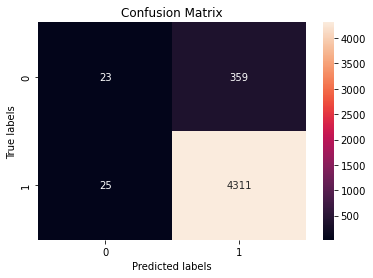

In [21]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(classification_report(y_test,y_pred))
confusion=confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True)
# Plot non-normalized confusion matrix 
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

#### Naive-Bayes with SMOTE

              precision    recall  f1-score   support

           0       0.90      0.10      0.18      4255
           1       0.53      0.99      0.69      4420

    accuracy                           0.55      8675
   macro avg       0.71      0.54      0.43      8675
weighted avg       0.71      0.55      0.44      8675



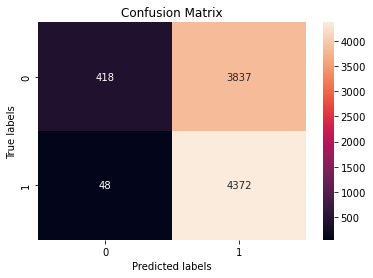

In [22]:
gnb = GaussianNB()
gnb.fit(X_trainb, y_trainb)
y_pred = gnb.predict(X_testb)

print(classification_report(y_testb,y_pred))
confusion=confusion_matrix(y_testb, y_pred)
sns.heatmap(confusion, annot=True)
# Plot non-normalized confusion matrix 
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

### Ada Boost

 Although the AdaBoost algorithm can be directly used to process imbalanced data, the algorithm focuses more on the misclassified samples than samples of minority class

              precision    recall  f1-score   support

           0       0.53      0.22      0.31       382
           1       0.93      0.98      0.96      4336

    accuracy                           0.92      4718
   macro avg       0.73      0.60      0.63      4718
weighted avg       0.90      0.92      0.91      4718



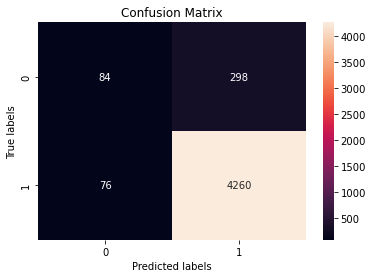

In [24]:
abc = AdaBoostClassifier(n_estimators=10,learning_rate=1)
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))
confusion=confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True)
# Plot non-normalized confusion matrix 
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

Summarizing, we have seen that AdaBoost is a very competitive algorithm for this application. Despite the difficulties of class imbalance, this
ensemble method has managed to achieve top performance with the rankings
it produces.


## Semi-supervised learning

In [25]:
X=X.values 
y=y.values 

In [26]:
#Unlabeled samples should have the label -1.
mask = sales.Insp ==2
column_name = 'Insp'
sales.loc[mask, column_name] = -1

In [27]:
sales["Insp"].value_counts()

-1    384478
 1     14458
 0      1268
Name: Insp, dtype: int64

In [28]:
sales_unlab=sales[sales.Insp ==-1 ]

In [29]:
X_unlab=sales_unlab[["ID","Prod","Uprice"]]
y_unlab=sales_unlab["Insp"]
X_unlab=X_unlab.values
y_unlab=y_unlab.values

### GaussianNB

In [42]:
gnb = GaussianNB()
self_training_model = SelfTrainingClassifier(gnb)

In [43]:
cv = KFold(n_splits=3)
recall_list0 = []
recall_list1 = []
precision_list0=[]
precision_list1=[]
f1_list0=[]
f1_list1=[]
accuracy_list = []
for train_indices, test_indices in cv.split(X):
        x_train, x_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        X_train_mixed = concatenate((x_train, X_unlab))
        y_train_mixed = concatenate((y_train,y_unlab))
        self_training_model.fit(X_train_mixed, y_train_mixed)
        y_pred=self_training_model.predict(x_test)
        p_score= precision_score(y_test,y_pred,average=None)
        r_score= recall_score(y_test,y_pred,average=None)
        f1_sscore= f1_score(y_test,y_pred,average=None)
        accuracy= accuracy_score(y_test,y_pred)
        accuracy_list.append(accuracy)
        recall_list0.append(r_score[0])
        recall_list1.append(r_score[1])
        precision_list0.append(p_score[0])
        precision_list1.append(p_score[1])
        f1_list0.append(f1_sscore[0])
        f1_list1.append(f1_sscore[1])

acc_score=np.mean(accuracy_list)
pre0_score=np.mean(precision_list0)
pre1_score=np.mean(precision_list1)
rec0_score=np.mean(recall_list0)
rec1_score=np.mean(recall_list1)
f10_score=np.mean(f1_list0)
f111_score=np.mean(f1_list1)

In [44]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Class", "Precision", "Recall", "F1", "Accuracy"]) 
  
# Add rows 
myTable.add_row(["0", "{:.2f}".format(pre0_score),"{:.2f}".format(rec0_score), "{:.2f}".format(f10_score),""]) 
myTable.add_row(["1","{:.2f}".format( pre1_score), "{:.2f}".format(rec1_score), "{:.2f}".format(f111_score),""]) 
myTable.add_row(["", "", "","", "{:.2f}".format(acc_score)]) 
print(myTable)

+-------+-----------+--------+------+----------+
| Class | Precision | Recall |  F1  | Accuracy |
+-------+-----------+--------+------+----------+
|   0   |    0.45   |  0.21  | 0.24 |          |
|   1   |    0.93   |  0.97  | 0.95 |          |
|       |           |        |      |   0.90   |
+-------+-----------+--------+------+----------+


### Ada Boost

In [38]:
abc = AdaBoostClassifier(n_estimators=10,learning_rate=1)
self_training_model = SelfTrainingClassifier(abc)

In [39]:
cv = KFold(n_splits=3)
recall_list0 = []
recall_list1 = []
precision_list0=[]
precision_list1=[]
f1_list0=[]
f1_list1=[]
accuracy_list = []
for train_indices, test_indices in cv.split(X):
        x_train, x_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        X_train_mixed = concatenate((x_train, X_unlab))
        y_train_mixed = concatenate((y_train,y_unlab))
        self_training_model.fit(X_train_mixed, y_train_mixed)
        y_pred=self_training_model.predict(x_test)
        p_score= precision_score(y_test,y_pred,average=None)
        r_score= recall_score(y_test,y_pred,average=None)
        f1_sscore= f1_score(y_test,y_pred,average=None)
        accuracy= accuracy_score(y_test,y_pred)
        accuracy_list.append(accuracy)
        recall_list0.append(r_score[0])
        recall_list1.append(r_score[1])
        precision_list0.append(p_score[0])
        precision_list1.append(p_score[1])
        f1_list0.append(f1_sscore[0])
        f1_list1.append(f1_sscore[1])

acc_score=np.mean(accuracy_list)
pre0_score=np.mean(precision_list0)
pre1_score=np.mean(precision_list1)
rec0_score=np.mean(recall_list0)
rec1_score=np.mean(recall_list1)
f10_score=np.mean(f1_list0)
f111_score=np.mean(f1_list1)

In [41]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Class", "Precision", "Recall", "F1", "Accuracy"]) 
  
# Add rows 
myTable.add_row(["0", "{:.2f}".format(pre0_score),"{:.2f}".format(rec0_score), "{:.2f}".format(f10_score),""]) 
myTable.add_row(["1","{:.2f}".format( pre1_score), "{:.2f}".format(rec1_score), "{:.2f}".format(f111_score),""]) 
myTable.add_row(["", "", "","", "{:.2f}".format(acc_score)]) 
print(myTable)

+-------+-----------+--------+------+----------+
| Class | Precision | Recall |  F1  | Accuracy |
+-------+-----------+--------+------+----------+
|   0   |    0.45   |  0.29  | 0.30 |          |
|   1   |    0.94   |  0.94  | 0.94 |          |
|       |           |        |      |   0.88   |
+-------+-----------+--------+------+----------+
